# dot plot of significant RBPs only
# count, log2fc
# size, color

In [1]:
import bento
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Get gene pattern labels

In [2]:
adata = bento.datasets.load_dataset("seqfish")

In [3]:
bento.tl.lp(adata)

In [4]:
gene_pattern = adata.var[[f"{p}_fraction" for p in bento._utils.PATTERN_NAMES]]
gene_pattern.columns = bento._utils.PATTERN_NAMES
gene_pattern = gene_pattern.idxmax(axis=1)
gene_pattern.value_counts()

none            2790
nuclear          474
nuclear_edge     229
cell_edge        128
cytoplasmic      105
dtype: int64

In [5]:
gene_pattern.name = "pattern"

# CLIP peak data

In [6]:
clip_data = pd.read_csv("../../data/clip_peaks.csv", index_col=0)

Identify regions bound by RBPs in each gene

In [7]:
clip_seq_features = (
    clip_data.groupby("Rbp")
    .apply(
        lambda rbp_df: rbp_df.pivot_table(
            index="gene", columns="Region", values="Log2fc", aggfunc="count"
        )
    )[
        [
            "3ss",
            "5ss",
            "CDS",
            "distintron",
            "five_prime_utrs",
            "proxintron",
            "three_prime_utrs",
        ]
    ]
    .fillna(0)
    .rename({"3ss": "three_ss", "5ss": "five_ss"}, axis=1)
    .reset_index()
)
clip_seq_features.columns = clip_seq_features.columns.str.lower()

seq_features = [
    "three_ss",
    "five_ss",
    "cds",
    "distintron",
    "five_prime_utrs",
    "proxintron",
    "three_prime_utrs",
]

clip_seq_features[seq_features] = clip_seq_features[seq_features] > 0

In [8]:
rbp_pattern_counts = (
    clip_seq_features.join(gene_pattern, on="gene")
    .pivot(index="gene", columns="rbp", values="pattern")
    .apply(lambda col: col.value_counts())
    .fillna(0)
    .astype(int)
)

In [9]:
rbp_pattern_counts = rbp_pattern_counts.loc[:, rbp_pattern_counts.sum() > 0]
log2_rbp_pattern_counts = np.log2(rbp_pattern_counts + 1)

In [10]:
rbp_peak_counts = clip_seq_features.groupby("rbp")[seq_features].sum().T
log2_rbp_peak_counts = np.log2(rbp_peak_counts + 1)

In [11]:
pattern_frac = rbp_pattern_counts / rbp_pattern_counts.sum()
peak_frac = rbp_peak_counts / rbp_peak_counts.sum()

In [12]:
corr = (
    pd.concat(
        [
            pattern_frac,
            peak_frac,
        ],
        axis=0,
    )
    .dropna(axis=1)
    .T.corr("spearman")
    .loc[rbp_pattern_counts.index, rbp_peak_counts.index]
)

corr = corr[
    [
        "cds",
        "five_ss",
        "three_ss",
        "five_prime_utrs",
        "three_prime_utrs",
        "proxintron",
        "distintron",
    ]
]
corr.columns = [
    "CDS",
    "5SS",
    "3SS",
    "5UTR",
    "3UTR",
    "proximal intron",
    "distal intron",
]

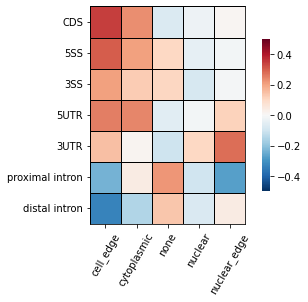

In [13]:
# plt.figure(figsize=(4,4))
ax = sns.heatmap(
    corr.T,
    square=True,
    cmap="RdBu_r",
    vmin=-0.5,
    vmax=0.5,
    center=0,
    linewidth=1,
    linecolor="black",
    cbar_kws={"shrink": 0.7},
)
plt.xticks(rotation=60)
sns.despine(ax=ax, top=False, right=False)
for spine in ax.spines.values():
    spine.set_edgecolor("black")

rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig("../../figures/fig4e_pattern_region_frac_spearman.svg")

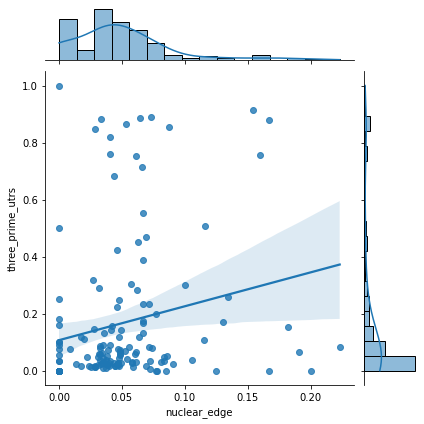

In [14]:
sns.jointplot(
    x=pattern_frac.loc["nuclear_edge"],
    y=peak_frac.loc["three_prime_utrs"],
    kind="reg",
)

In [15]:
def log2fc_gene(values):
    log2fc = dict()
    for k, v in values.to_dict().items():
        rest = (values.mean() * len(values) - v) / len(values)
        log2fc[k] = np.log2((v + 1) / rest + 1)
    log2fc = pd.Series(log2fc).replace({np.inf: 0, -np.inf: 0})
    return log2fc

In [16]:
rbp_pattern_counts = rbp_pattern_counts.drop("none", errors="ignore")

In [17]:
rbp_pattern_counts = rbp_pattern_counts.loc[:, rbp_pattern_counts.sum() > 2]

In [18]:
# Start with log2fc of pattern counts
log2fc_rbp_patterns = rbp_pattern_counts.apply(log2fc_gene)

# Long df of log2fc
log2fc_long = (
    log2fc_rbp_patterns.reset_index()
    .melt(id_vars="index")
    .rename({"value": "log2fc"}, axis=1)
)

# Long df of log2 counts
log2_count_long = (
    log2_rbp_pattern_counts.reset_index()
    .melt(id_vars="index")
    .rename({"value": "log2_target_count"}, axis=1)
)

# Long df of counts
count_long = (
    rbp_pattern_counts.reset_index()
    .melt(id_vars="index")
    .rename({"value": "target_count"}, axis=1)
)

# Join log2fc and counts
rbp_long = (
    log2fc_long.set_index(["index", "rbp"])
    .join(count_long.set_index(["index", "rbp"]))
    .reset_index()
)

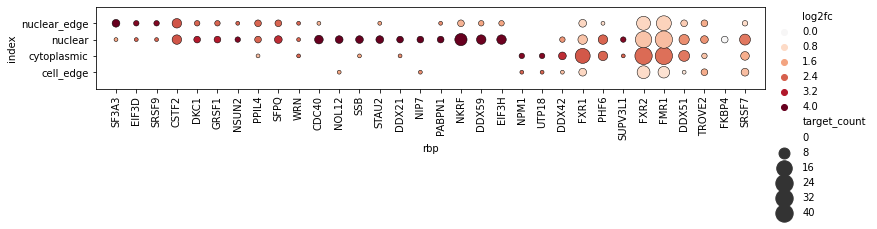

In [19]:
ntop = 10
top_rbps = (
    rbp_long.sort_values(["index", "log2fc"], ascending=False)
    .groupby("index")
    .head(ntop)["rbp"]
    .unique()
    .tolist()
)

top_markers = (
    rbp_long.set_index("rbp")
    .loc[top_rbps]
    .reset_index()
    .set_index("index")
    .loc[["cell_edge", "cytoplasmic", "nuclear", "nuclear_edge"]]
)

plt.figure(figsize=(ntop * 1.2, 1.5))
ax = sns.scatterplot(
    data=top_markers,
    y="index",
    x="rbp",
    hue="log2fc",
    hue_norm=(-4, 4),
    size="target_count",
    size_norm=(0, 20),
    sizes=(0, 300),
    palette="RdBu_r",
    linewidth=0.5,
    edgecolor="black",
)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=(1, 1.05), frameon=False)
ax.set_xlim(-1, len(top_rbps))
ax.set_ylim(-1, 4)


rc = {"svg.fonttype": "none", "font.family": "Arial"}

with plt.rc_context(rc):
    plt.savefig("../../figures/fig4a_rbp_log2fc_targets.svg")